# Part 0 : Dataset Preparation

### Import essential libraries needed

##### Gensim is selected as it offers the ability to use pre-trained embeddings and compatibility with other libraries such as Scikit-learn and Pandas for downstream tasks in machine learning workflows.

In [108]:
#Installing packages
!pip install datasets
!pip install gensim
!pip install nltk
%pip install tf_keras
%pip install ktrain

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [109]:
import os
os.environ["TF_USE_LEGACY_KERAS"]="1"

### Load in dataset

In [110]:
import gensim
from gensim.utils import simple_preprocess
import numpy as np
from datasets import load_dataset
from matplotlib import pyplot as plt 

In [111]:
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train'] 
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [112]:
print(train_dataset[:5])
print(validation_dataset[:5])
print(test_dataset[:5])

{'text': ['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle-earth .', 'effective but too-tepid biopic', 'if you sometimes like to go to the movies to have fun , wasabi is a good place to start .', "emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one ."], 'label': [1, 1, 1, 1, 1]}
{'text': ['compassionately explores the seemingly irreconcilable situation between conservative christian parents and their estranged gay and lesbian children .', 'the soundtrack alone is worth the price of admission .', 'rodriguez does a splendid job of racial profiling hollywood style--casting excellent

### Text Preprocessing for Word2Vec Training

##### We initialize a list to store the processed words from our training dataset. Each sentence is preprocessed by performing the following steps:

##### Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long, uses ~gensim.utils.tokenise internally.

In [113]:
# Initialise a list to hold processed sentences
processed_sentences = []
max_sentence_length = 0

# Iterate over the text data in the training dataset
for text in train_dataset['text']:
        # Preprocess the sentence (tokenisation, lowercasing, removing punctuation)
        processed_sentence = simple_preprocess(text)

        # Calculate the longest sentence length for later use
        if (len(processed_sentence) > max_sentence_length):
                max_sentence_length = len(processed_sentence)
        
        # Append the processed sentence to the list
        processed_sentences.append(processed_sentence)

In [114]:
# Print the first 5 processed sentences
print(processed_sentences[:5])

[['the', 'rock', 'is', 'destined', 'to', 'be', 'the', 'st', 'century', 'new', 'conan', 'and', 'that', 'he', 'going', 'to', 'make', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', 'jean', 'claud', 'van', 'damme', 'or', 'steven', 'segal'], ['the', 'gorgeously', 'elaborate', 'continuation', 'of', 'the', 'lord', 'of', 'the', 'rings', 'trilogy', 'is', 'so', 'huge', 'that', 'column', 'of', 'words', 'cannot', 'adequately', 'describe', 'co', 'writer', 'director', 'peter', 'jackson', 'expanded', 'vision', 'of', 'tolkien', 'middle', 'earth'], ['effective', 'but', 'too', 'tepid', 'biopic'], ['if', 'you', 'sometimes', 'like', 'to', 'go', 'to', 'the', 'movies', 'to', 'have', 'fun', 'wasabi', 'is', 'good', 'place', 'to', 'start'], ['emerges', 'as', 'something', 'rare', 'an', 'issue', 'movie', 'that', 'so', 'honest', 'and', 'keenly', 'observed', 'that', 'it', 'doesn', 'feel', 'like', 'one']]


In [115]:
import keras
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

In [116]:
tokenizer = Tokenizer(num_words=10000)
train_labels = train_dataset['label']
train_sentences = processed_sentences

# Assigns each word in the vocabulary to an index
tokenizer.fit_on_texts(train_sentences)

# Sets each word in a sentence to its index, 0 being reserved for padding
train_sequences = tokenizer.texts_to_sequences(train_sentences)

# Pad sentences to max_sentence_length, which will be the dimension of our trained weights
train_padded = keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_sentence_length, padding='post', truncating='post')

train_labels = np.array(train_labels)

### Preparing the validation and test sets

In [118]:
# Do similar preparation for validation set
val_sentences = []

# Iterate over the text data in the validation dataset
for text in validation_dataset['text']:
        # Preprocess the sentence (tokenisation, lowercasing, removing punctuation)
        processed_sentence = simple_preprocess(text)
        # Append the processed sentence to the list
        val_sentences.append(processed_sentence)

val_labels = validation_dataset['label']
val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=max_sentence_length, padding='post', truncating='post')

val_labels = np.array(val_labels)

In [119]:
# Do similar preparation for test set
test_sentences = []

# Iterate over the text data in the test dataset
for text in test_dataset['text']:
        # Preprocess the sentence (tokenisation, lowercasing, removing punctuation)
        processed_sentence = simple_preprocess(text)
        # Append the processed sentence to the list
        test_sentences.append(processed_sentence)

test_labels = test_dataset['label']
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_sentence_length, padding='post', truncating='post')

test_labels = np.array(test_labels)

# Part 1. Preparing Word Embeddings

### Gensim comes with several already pre-trained models, in the Gensim-data repository:

- `conceptnet-numberbatch-17-06-300`
- `word2vec-ruscorpora-300`
- `word2vec-google-news-300`
- `glove-wiki-gigaword-50`
- `glove-wiki-gigaword-100`
- `glove-wiki-gigaword-200`
- `glove-wiki-gigaword-300`
- `glove-twitter-25`
- `glove-twitter-50`
- `glove-twitter-100`
- `glove-twitter-200`
- `__testing_word2vec-matrix-synopsis`

##### In the model names, the numbers refer to the dimensionality of the word vectors (embeddings) for each pre-trained model, this means that higher dimensions capture more complex relationships between words but require more memory and computational resources.


##### Model name examples:

- **`word2vec-google-news-300`**: A Word2Vec model trained on Google News, providing embeddings with 300 dimensions.
- **`glove-twitter-100`**: A GloVe model trained on Twitter data, with 100-dimensional embeddings specialized for social media language.

##### We will explore a few of these pre trained models to see which models will do better in migitating number of OOV words in our dataset. To keep it fair, we will select the models with the highest dimentions from each category


In [120]:
from gensim.models import KeyedVectors

glove_wiki_300 = KeyedVectors.load('./glove_wiki_gigaword_300.model')

print("Models loaded from local files.")

Models loaded from local files.


##### Question 1(a): Calculate vocabulary size from processed sentences previously in part 0

In [121]:
# Iterate over the list of processed sentences and get unique words
train_vocab = set(word for sentence in processed_sentences for word in sentence)

# (1a) Vocabulary size
vocab_size = len(train_vocab)
print("Size of vocabulary in training data:", vocab_size)

Size of vocabulary in training data: 16288


##### Question 1(b) Identify out-of-vocabulary (OOV) words while taking into account various models

In [122]:
# Vocabulary size of glove_wiki_300 model
glove_wiki_300_vocab_size = len(glove_wiki_300.key_to_index)
print("Size of vocabulary in glove_wiki_300 model:", glove_wiki_300_vocab_size)

# (b) Count OOV words
oov_words = [word for word in train_vocab if word not in glove_wiki_300]
oov_count = len(oov_words)
print("Number of OOV words:", oov_count)

Size of vocabulary in glove_wiki_300 model: 400000
Number of OOV words: 580


##### From this analysis, we can tell that glove_wiki_300 models is the best performing model on the training dataset, as it has a smaller vocabulary as compared to the other models, but still produced the least number of OOV words. We will use the glove_wiki_300 model from now onwards.

### Step 3: Prepare the Embedding Matrix

##### Create an embedding matrix for later parts, each row corresponds to the embedding of a specific word in the training vocabulary. For OOV words, we will use a zero vector.

In [123]:
# Define the embedding dimension
embedding_dim = glove_wiki_300.vector_size

# Get the size of the vocabulary. Index 0 is reserved for padding
train_vocab_size = len(train_vocab) + 1  # Make sure train_vocab is a set or list

# Initialize the embedding matrix
embedding_matrix = np.zeros((train_vocab_size, embedding_dim))

# Populate the embedding matrix
for word, idx in tokenizer.word_index.items():
    if word in glove_wiki_300:
        embedding_matrix[idx] = glove_wiki_300[word]
    else:
        # Use zero vector for OOV words
        embedding_matrix[idx] = np.zeros(embedding_dim)


In [124]:
# Print the shape of the embedding matrix
print("Shape of the embedding matrix:", embedding_matrix.shape)

# Print the first 5 embeddings
print("First 5 embeddings:")
print(embedding_matrix[:5])  # Adjust the slice as needed

Shape of the embedding matrix: (16289, 300)
First 5 embeddings:
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.04656     0.21318001 -0.0074364  ...  0.0090611  -0.20988999
   0.053913  ]
 [ 0.038466   -0.039792    0.082747   ... -0.33427     0.011807
   0.059703  ]
 [-0.076947   -0.021211    0.21270999 ...  0.18351001 -0.29183
  -0.046533  ]
 [-0.25756001 -0.057132   -0.67189997 ... -0.16043     0.046744
  -0.070621  ]]


# Part 2. Model Training & Evaluation - RNN

### Method 1

In [125]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers.legacy import Adam
import ktrain

In [126]:
# Setup embedding layer
num_tokens = train_vocab_size

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    mask_zero=True,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

In [127]:
# Design model
model=Sequential([
    embedding_layer,
    SimpleRNN(300), 
    Dense(1, activation='sigmoid')
])

print(model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         4886700   
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 300)               180300    
                                                                 
 dense_11 (Dense)            (None, 1)                 301       
                                                                 
Total params: 5067301 (19.33 MB)
Trainable params: 180601 (705.47 KB)
Non-trainable params: 4886700 (18.64 MB)
_________________________________________________________________
None


In [128]:
model.compile(loss='binary_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])

#### Explore different learning rates

In [129]:
learner = ktrain.get_learner(model, train_data=(train_padded, train_labels), batch_size=32)

In [130]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024


/opt/anaconda3/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


267/267 [==============================] - 9s 31ms/step - loss: 0.7404 - accuracy: 0.4905
Epoch 2/1024
267/267 [==============================] - 8s 31ms/step - loss: 0.7271 - accuracy: 0.4987
Epoch 3/1024
267/267 [==============================] - 8s 32ms/step - loss: 0.6533 - accuracy: 0.6098
Epoch 4/1024
267/267 [==============================] - 8s 32ms/step - loss: 0.6271 - accuracy: 0.6532
Epoch 5/1024
267/267 [==============================] - 8s 31ms/step - loss: 0.8038 - accuracy: 0.5342
Epoch 6/1024
267/267 [==============================] - 5s 19ms/step - loss: 3.1549 - accuracy: 0.5111


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 5.44E-05
	Min numerical gradient (purple): 2.52E-04
	Min loss divided by 10 (omitted from plot): 6.04E-05


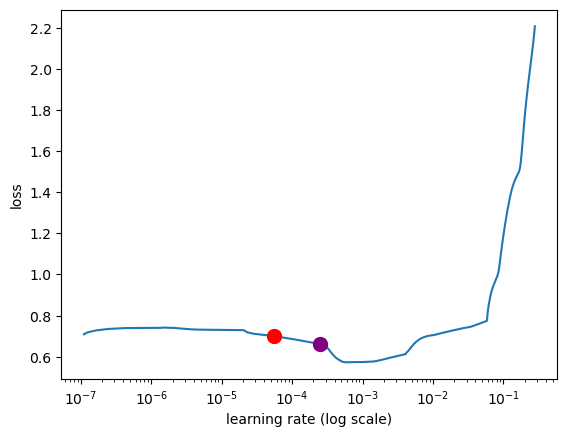

In [131]:
learner.lr_plot(suggest=True)

With this data, we choose preliminarily to use a static learning rate of 2e-4

#### Train model

In [132]:
model=Sequential([
    embedding_layer,
    SimpleRNN(300), 
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', 
            optimizer=Adam(learning_rate=2e-4), 
            metrics=['accuracy'])
history = model.fit(train_padded, train_labels,batch_size=16, epochs=12, validation_data=(val_padded, val_labels))

Epoch 1/12
534/534 [==============================] - 12s 22ms/step - loss: 0.6056 - accuracy: 0.6674 - val_loss: 0.5590 - val_accuracy: 0.6998
Epoch 2/12
534/534 [==============================] - 12s 23ms/step - loss: 0.4950 - accuracy: 0.7600 - val_loss: 0.5380 - val_accuracy: 0.7317
Epoch 3/12
534/534 [==============================] - 12s 23ms/step - loss: 0.4442 - accuracy: 0.7899 - val_loss: 0.5632 - val_accuracy: 0.7270
Epoch 4/12
534/534 [==============================] - 12s 23ms/step - loss: 0.3995 - accuracy: 0.8181 - val_loss: 0.5796 - val_accuracy: 0.7195
Epoch 5/12
534/534 [==============================] - 13s 24ms/step - loss: 0.3449 - accuracy: 0.8479 - val_loss: 0.6146 - val_accuracy: 0.7148
Epoch 6/12
534/534 [==============================] - 12s 23ms/step - loss: 0.2824 - accuracy: 0.8841 - val_loss: 0.7103 - val_accuracy: 0.7186
Epoch 7/12
534/534 [==============================] - 12s 23ms/step - loss: 0.2188 - accuracy: 0.9123 - val_loss: 0.7862 - val_accuracy:

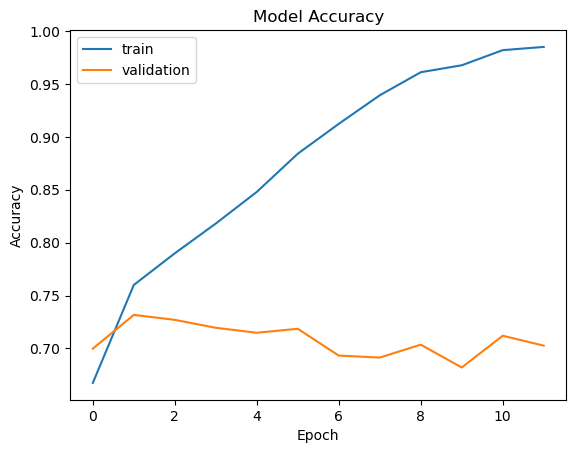

In [133]:
# plotting the training accuracy and the validation accuracy from the model against number of epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [134]:
# Run on test data
print('\nTest loss and accuracy is:')
scores = model.evaluate(x=test_padded, y=test_labels)


Test loss and accuracy is:
34/34 [==============================] - 0s 11ms/step - loss: 1.2305 - accuracy: 0.7205
